In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [2]:
weight = [267.8, 265.6, 262.9, 262.1, 260.4, 258.7, 263.2, 264.2, 265.0, 260.3, 261.6, 260.5]
fat = []
xdata = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [3]:
def reals(x):
    rpart = np.real(x)
    ipart = np.imag(x)
    if np.isscalar(rpart) and np.isscalar(ipart):
        return np.array([rpart, ipart])
    return np.concatenate([rpart, ipart], axis=0)

def cplx(x):
    N = len(x)
    x_real = x[:N//2]
    x_imag = x[N//2:]
    return x_real + x_imag*1j

def cplxwrap(func):
    def inner(x, *args):
        return reals(func(cplx(x), *args))
    return inner

In [4]:
@cplxwrap
def f4g(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi, hr, hi, ir, ii):
    return (ar+ai*1j) + (br+bi*1j)*np.exp(-(cr+ci*1j)*x) + (dr+di*1j)*np.exp(-(er+ei*1j)*x) + \
        (fr+fi*1j)*np.exp(-(gr+gi*1j)*x) + (hr+hi*1j)*np.exp(-(ir+ii*1j)*x)

@cplxwrap
def f4gp(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi, hr, hi, ir, ii):
    return -(br+bi*1j)*(cr+ci*1j)*np.exp(-(cr+ci*1j)*x) - (dr+di*1j)*(er+ei*1j)*np.exp(-(er+ei*1j)*x) - \
        (fr+fi*1j)*(gr+gi*1j)*np.exp(-(gr+gi*1j)*x) - (hr+hi*1j)*(ir+ii*1j)*np.exp(-(ir+ii*1j)*x)

@cplxwrap
def j4g(x, ar, ai, br, bi, cr, ci, dr, di, er, ei, fr, fi, gr, gi, hr, hi, ir, ii):
    jac = [np.ones_like(x), np.ones_like(x)*1j,
           np.exp(-(cr+ci*1j)*x), np.exp(-(cr+ci*1j)*x)*1j,
           -(br+bi*1j)*x*np.exp(-(cr+ci*1j)*x), -(br+bi*1j)*x*np.exp(-(cr+ci*1j)*x)*1j,
           np.exp(-(er+ei*1j)*x), np.exp(-(er+ei*1j)*x)*1j,
           -(dr+di*1j)*x*np.exp(-(er+ei*1j)*x), -(dr+di*1j)*x*np.exp(-(er+ei*1j)*x)*1j,
           np.exp(-(gr+gi*1j)*x), np.exp(-(gr+gi*1j)*x)*1j,
           -(fr+fi*1j)*x*np.exp(-(gr+gi*1j)*x), -(fr+fi*1j)*x*np.exp(-(gr+gi*1j)*x)*1j,
           np.exp(-(ir+ii*1j)*x), np.exp(-(ir+ii*1j)*x)*1j,
           -(hr+hi*1j)*x*np.exp(-(ir+ii*1j)*x), -(hr+hi*1j)*x*np.exp(-(ir+ii*1j)*x)*1j]
    return np.transpose(jac)

In [5]:
xdata = np.array(xdata)
weight = np.array(weight)
fat = np.array(fat)

xc = reals(xdata)
yc = reals(weight)
fc = reals(fat)

In [6]:
uc_bounds = [
    (0, 1000), (-np.inf, np.inf),
    (-np.inf, np.inf), (-np.inf, np.inf),
    (-10, 10), (-np.inf, np.inf),
    (-np.inf, np.inf), (-np.inf, np.inf),
    (-10, 10), (-np.inf, np.inf),
    (-np.inf, np.inf), (-np.inf, np.inf),
    (-10, 10), (-np.inf, np.inf),
    (-np.inf, np.inf), (-np.inf, np.inf),
    (-10, 10), (-np.inf, np.inf),
]

x0 = [500, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]

In [14]:
def lsfwrap(f, x, y):
    def func(params):
        return f(x, *params) - y
    return func

def lsjwrap(j, x):
    def func(params):
        return j(x, *params)
    return func

def lswrap(f, x, y, j, bounds, x0):
    res = optimize.least_squares(
        fun=lsfwrap(f, x, y),
        x0=x0,
        jac=lsjwrap(j, x),
        bounds=np.transpose(bounds),
        verbose=1,
        ftol=1e-12, xtol=1e-12, gtol=1e-12,
        max_nfev=10000,
        method='dogbox',
        x_scale='jac',
    )
    return res

In [15]:
%%time
uc_wopt = lswrap(f4g, xc, yc, j4g, uc_bounds, x0)
c = uc_wopt.x[::2] + uc_wopt.x[1::2]*1j
print(f'w(t) = ({c[0]:.4g}) + ({c[1]:.3g})*e^(({-c[2]:.3g})*t) + ({c[3]:.3g})*e^(({-c[4]:.3g})*t)')
print(f'           + ({c[5]:.3g})*e^(({-c[6]:.3g})*t) + ({c[7]:.3g})*e^(({-c[8]:.3g})*t)')
print(f'w\'(0) =', 7*cplx(f4gp(reals([0]), *uc_wopt.x))[0], 'lbs/week')
print(f'w\'(28) =', 7*cplx(f4gp(reals([28]), *uc_wopt.x))[0], 'lbs/week')

`ftol` termination condition is satisfied.
Function evaluations 306, initial cost 3.3802e+05, final cost 2.5717e+00, first-order optimality 4.04e-06.
w(t) = (262.3+0.0508j) + (1.07-1.29j)*e^((-0.0578+0.983j)*t) + (-1.03+6.2j)*e^((-0.201-1.14j)*t)
           + (5.2-4.61j)*e^((-0.374-1.4j)*t) + (0.134-0.24j)*e^((0.131-3.02j)*t)
w'(0) = (-4.404775718909416-34.69915571562974j) lbs/week
w'(28) = (170.56243117053697+153.93141693289354j) lbs/week
CPU times: user 257 ms, sys: 0 ns, total: 257 ms
Wall time: 263 ms


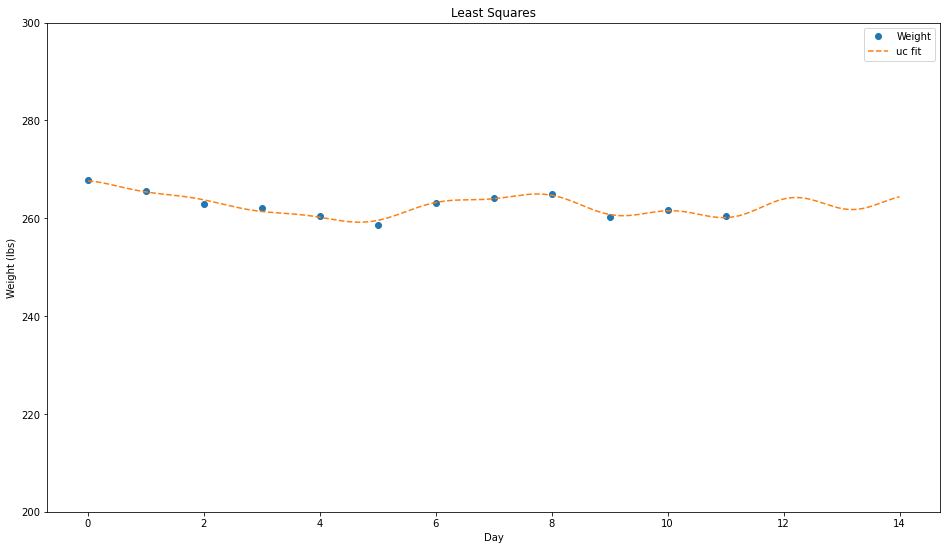

In [16]:
fig = plt.figure(figsize=(16, 9))
x = np.linspace(0, 14, 1000)
plt.plot(xdata, weight, 'o', label='Weight')
plt.plot(x, np.real(cplx(f4g(reals(x), *uc_wopt.x))), '--', label='uc fit')
plt.title('Least Squares')
plt.xlabel('Day')
plt.ylabel('Weight (lbs)')
plt.ylim((200, 300))
plt.legend()
plt.show()

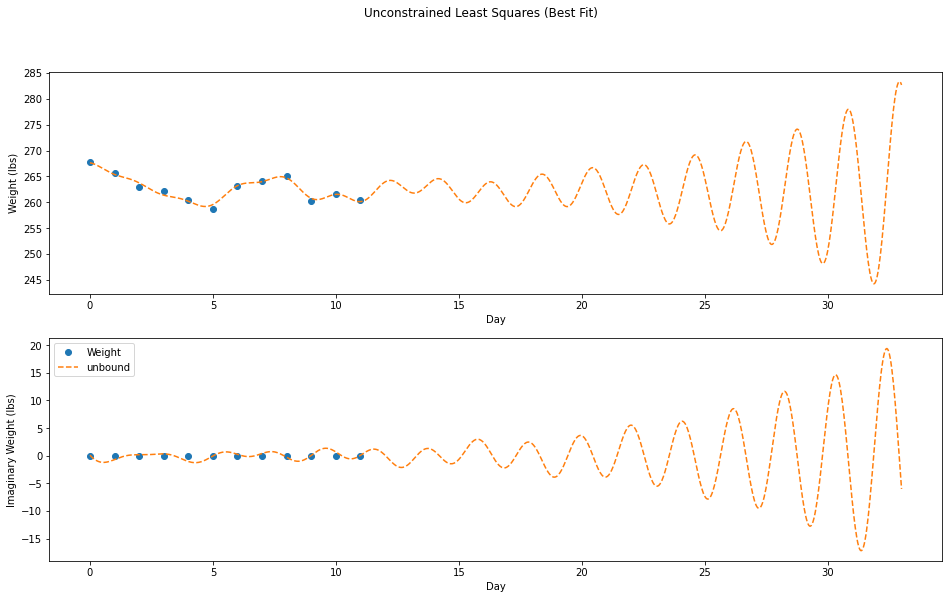

In [17]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 9))
x = np.linspace(0, 3 * xdata[-1], 1000)
ax1.plot(xdata, np.real(weight), 'o', label='Weight')
ax1.plot(x, np.real(cplx(f4g(reals(x), *uc_wopt.x))), '--', label='unbound')
ax2.plot(xdata, np.imag(weight), 'o', label='Weight')
ax2.plot(x, np.imag(cplx(f4g(reals(x), *uc_wopt.x))), '--', label='unbound')
plt.suptitle('Unconstrained Least Squares (Best Fit)')
ax1.set(xlabel='Day', ylabel='Weight (lbs)')
ax2.set(xlabel='Day', ylabel='Imaginary Weight (lbs)')
plt.legend()
plt.show()

In [11]:
%%time
uc_wopt = lswrap(f4g, xc, fc, j4g, uc_bounds, x0)
c = uc_wopt.x[::2] + uc_wopt.x[1::2]*1j
print(f'w(t) = ({c[0]:.4g}) + ({c[1]:.3g})*e^(({-c[2]:.3g})*t) + ({c[3]:.3g})*e^(({-c[4]:.3g})*t)')
print(f'           + ({c[5]:.3g})*e^(({-c[6]:.3g})*t) + ({c[7]:.3g})*e^(({-c[8]:.3g})*t)')

ValueError: operands could not be broadcast together with shapes (24,) (0,) 

ValueError: x and y must have same first dimension, but have shapes (12,) and (0,)

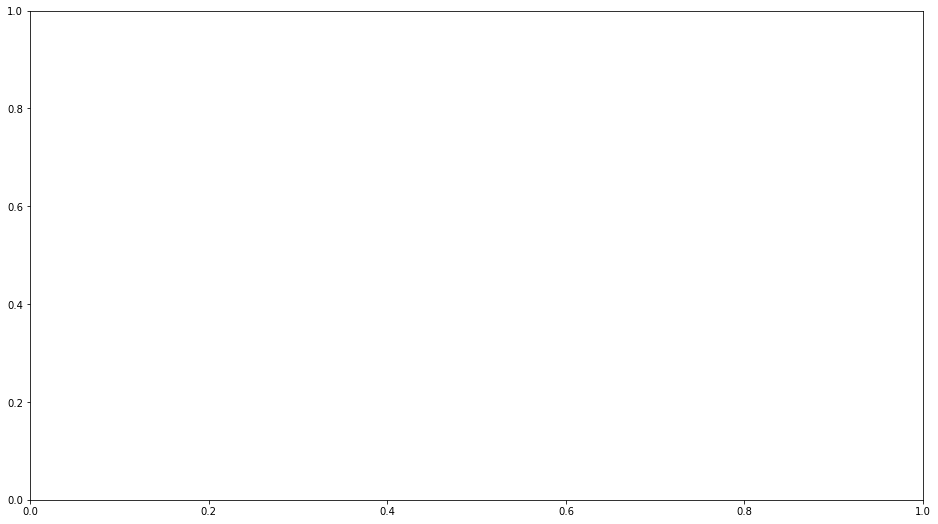

In [12]:
fig = plt.figure(figsize=(16, 9))
x = np.linspace(0, 2 * xdata[-1], 1000)
plt.plot(xdata, fat, 'o', label='Body Fat')
plt.plot(x, np.real(cplx(f4g(reals(x), *uc_wopt.x))), '--', label='uc fit')
plt.title('Least Squares')
plt.xlabel('Day')
plt.ylabel('Weight (lbs)')
plt.ylim((20, 40))
plt.legend()
plt.show()

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
fig = plt.figure(figsize=(16, 9))
x = np.linspace(0, 14, 1000)
plt.title('Least Squares')
plt.xlabel('Day')
plt.ylabel('Weight (lbs)')
plt.ylim((200, 300))

def fun(x, a, b, c, d, e, f, g, h, i):
    return np.real(cplx(f4g(reals(x), a, 0, b, 0, c, 0, d, 0, e, 0, f, g, h, i, f, -g, h, -i)))

w0 = 267.8
winf = 128
wdot = -5/7

c1 = winf
c5 = 7/5*np.log(2)
c4 = c5*2*wdot/(np.exp(-7*c5) - 1)
c7 = 2/7*np.pi
c8 = 1/(np.tan(c7)*np.sin(c7) + np.cos(c7))
c6 = c8*np.tan(c7)
c2 = w0 - winf - c4 - c8
c3 = -wdot/c2

@widgets.interact(a=c1, b=c2, c=c3, d=c4, e=c5, f=c8, g=c6, h=0, i=c7)
def update(a, b, c, d, e, f, g, h, i):
    plt.clf()
    plt.plot(xdata, weight, 'o', label='Weight')
    plt.plot(x, fun(x, a, b, c, d, e, f, g, h, i), '--', label='uc fit')
    plt.legend()